In [1]:
# BEAM WAIST & BUTTERFLY CALIBRATION ASSIST TOOL FOR PCI 
# Ross Johnston 2021/05/13
"""
SUMMARY
My application of theoretical fitting procedures to the experimental butterfly curves is fundamentally limited by small sampling (due slow rate measurement and drift throughout) and unncertainty in knowing the beam waist at the samples surface (diff in app & cal surface). As a result only the calibration results shown in markdown from the much simpler, 3rd order polyfits are of merit at the moment.


NOTATION
i). Imaging stage units that are experimentally logged are a scalar offset away from Imaginary stage values derived from theory. 
ii). Z_apperture as shown here corresponds to beam waists, as experimentally derived from circular aperture studies. In order to translate this to z-position the surface offset between apertue and calibration sample must be accuratlye known.

LIMITATIONS
i). Only works if the material properties (that feed into dispersion function) are accurate
ii). Given the limited size of the experimental data set, this method can only reliable fit Imaging stage, so z_pos i.e pump                  beam  waist must be accuratley determined via aperture / razor fitting.
iii). Absolute scaling between exp and theory is not known here and so the normalised curves are fitted instead. As a result of              normalisation, the technique is further limited by error on individual points

DEVELOPMENTS
i). Error propogation from fitting polynomial to the emperical data 
ii). Fitting to the full complex dispersion function by accounting for phase in experimental data and any vertical offsets (Normalised phase??)
iii). Pass a standard error for each point onto curve_fit
iv). As LUKAS did with FINESSE: Profile the probe beam on its path to the PD such that rough allignment / 2-way calibration can be achieved from just apperture measurements. In other words, experimentally derive the offset as described in the sections below, that shifts the theoretical dispersion peak towards IS.

"""
print('')

Dispersion output is of magnitude and phase, following on from the equations for Bulk:

$$
DF_x (\zeta,\epsilon,\Omega) = \frac{A*n}{\sin{\beta}} *\int_{0}^{N \cdot \frac{\pi}{\Omega}} \operatorname{Im}\left(\frac{1}{\sqrt{1+\tau+\frac{\zeta}{\varepsilon \cdot \zeta+i}}}\right) \cdot \exp (-i \cdot \Omega \cdot \tau) d \tau
$$

and surface:

$$
DF_x (\zeta,\epsilon,\Omega) = A* \int_{0}^{N \cdot \frac{\pi}{\Omega}} \operatorname{Im}\left(\frac{1}{1+\tau+\frac{\zeta}{\varepsilon \cdot \zeta+i}}\right) \cdot \exp (-i \cdot \Omega \cdot \tau) d \tau
$$

where:

$$
\mathrm{A}=\sqrt{\frac{\pi}{8}} \cdot \frac{\mathrm{w}_{0}}{\lambda} \cdot \frac{\mathrm{dndT}}{\mathrm{k}}
$$


In [1]:
## Functions 

# !!! Makse sure you have run cmd\ pip install -r requirements.txt

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from optical_equations import *

## 1064nm Fitting

Z Apperture is at 7.1mm -> z Cal is at 6.23mm. This is 0.2mm greater than previously used value, provided that the difference in surace depth between calibration and aperture is indeed 0.87mm
Pump beam waist is 3.62e-05m


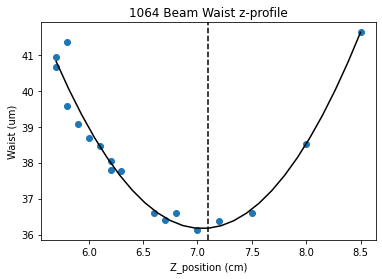

In [3]:
## 1064 Beam waist optimisation 

arr = np.loadtxt('1064App2.txt')
waist_arr = np.asarray([[x[0],pow2waist(75/2,x[2],x[1])] for x in arr])
plt.scatter(waist_arr[:,0],waist_arr[:,1])
plt.title('1064 Beam Waist z-profile')
plt.ylabel('Waist (um)')
plt.xlabel('Z_position (cm)')

#data_arr = np.asarray([[a,b] for a,b in zip(arr[:,0],waist_arr)])
data_arr = waist_arr[np.argsort(waist_arr[:, 0])]

p_waist = np.poly1d(np.polyfit(data_arr[:,0], -data_arr[:,1], 2))

IS = np.linspace(data_arr[0][0],data_arr[-1][0],25)
plt.plot(IS,-p_waist(IS),color='black')
peaks = IS[find_peaks(p_waist(IS))[0]]
for i in peaks:
    plt.axvline(x=i,color='black',linestyle='--')
    #print('IS is at: ',round(i,2),'mm')

waist_1064 = np.round(-p_waist(peaks[0])*1e-6,7) 

print('Z Apperture is at {}mm -> z Cal is at {}mm. This is 0.2mm greater than previously used value, provided that the difference in surace depth between calibration and aperture is indeed 0.87mm'.format(peaks[0],np.round(peaks[0]-0.87,3)))
print('Pump beam waist is {0}m'.format(waist_1064))
#popt, = curve_fit(pow2waist,waist_arr[:,0],waist_arr[:,1],p0)



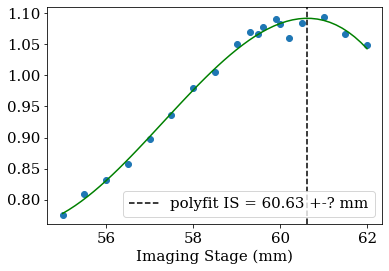

In [4]:
## 1064 Imaging stage (polyfit)

exp_data = np.loadtxt('1064_Butterfly2.txt')
exp_data = exp_data[np.argsort(exp_data[:,0])]
p_disp = np.poly1d(np.polyfit(exp_data[:,0], exp_data[:,1], 3))

fit_range = np.linspace(np.min(exp_data[:,0]),np.max(exp_data[:,0]),50)

plt.rcParams.update({'font.size': 15})
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.scatter(exp_data[:,0],exp_data[:,1])
plt.plot(fit_range,p_disp(fit_range),color='green')
#plt.plot(fit_range,dp(fit_range))

# POLYFIT 
# compute local maxima
# excluding range boundaries
dp = p_disp.deriv().r
r_dp = dp[dp.imag==0].real
test = p_disp.deriv(2)(dp) 
x_max = r_dp[test<0]
y_max = p_disp(x_max) 

plt.xlabel('Imaging Stage (mm)')
plt.axvline(x_max,color='black',linestyle='--',label='polyfit IS = {} +-? mm'.format(np.round(x_max[0],2)))

# CURVEFIT 
def fit_func(x, *coeffs):
    y = np.polyval(coeffs, x)
    """
    This code evalues the x-coordinate of the local maximum 
    p = np.poly1d(coeffs)
    dp = p.deriv().r
    r_dp = dp[dp.imag==0].real
    test = p.deriv(2)(dp) 
    x_min = r_dp[test<0]
    y_min = p(x_min) 
    """
    return y

p_coeff = p_disp.coefficients

p_opt, p_cov = curve_fit(fit_func,exp_data[:,0],exp_data[:,1],p0=list(p_coeff))

p_err = np.sqrt(np.diag(p_cov))


def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

array = np.asarray([list(signif(x,6)) for x in zip(p_opt,p_err)])
#print(array)

plt.legend()

From these simple polyfits the setup for the 1064nm laser reads as:

## z_pos = 6mm , IS = 60.6 mm

Note that z_pos defaults here, to the measured point of 6mm but ideally this should be at 6.2mm

Although without any assoicated errors (z assumed to be exact) it is hard to extract in confidence in this fit. 

The challenge comes particularly in deriving an error on the IS. It is easy enough to deirve one through error propogation for the y but the outstanding challenge, lies in root evaluation determine one for the maximum that properly accounts for the errors on the polyfit coeefs and their covariance, where significant.



In [5]:
## 1064 Imaging stage (Numerical Fit) 


# Note: Simultaneous beam waist fitting, results in cell taking up 1 minute to run

source = 'surface'

exp_data = np.loadtxt('1064_Butterfly2.txt')
exp_data = exp_data[np.argsort(exp_data[:,0])]

#As both exp & theory should be normalised this line is required. However in all but the numerical fit (IS & w0), it leads to large #disagreements in final IS
exp_data[:,1] = exp_data[:,1]/y_max


def offset_disp(x,off,w0):

    #Slider here optimises the x alignment of both curves (off)
    disp_x = x - off
    #Find theoreretical peak to normalise the data
    normspace = np.linspace(np.max(disp_x),np.min(disp_x),20)
    normspace = np.asarray([Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0] for d in normspace])
    normf = normspace[find_peaks(normspace)[0][0]]
    disp = np.asarray([Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0]/normf for d in disp_x])
    return disp

p_opt, p_cov = curve_fit(offset_disp,exp_data[:,0],exp_data[:,1],p0=[64.5,37e-6],bounds=([58,34e-6],[70,40e-6]))

#print(p_opt,p_cov)
perr = np.sqrt(np.diag(p_cov))

# Evaluate Optimal Imaging stage 
x_z = np.linspace(-15,15,60)
D_fs = np.asarray([Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,p_opt[1],115e-6,1310e-9,d,source=source)[0] for d in x_z])
peak = p_opt[0]+x_z[find_peaks(D_fs)[0][0]]
#print(peak)
print('Imaging stage: {0}+-{1} mm , Beam waist {2}+-{3} um'.format(np.round(peak,2),np.round(perr[0],2),np.round(p_opt[1],7),np.round(perr[1],7)))



Imaging stage: 60.42+-0.24 mm , Beam waist 4e-05+-2.2e-06 um


In [6]:
# Fit z from optimised Beam waist
# !!! IGNORE UNTIL w0 unccertanties are reduced

def poly_roots(p,y_value):
    # p should be of type poly1d 

    new_p = p.coefficients.copy() #Prevents original being overwritten
    new_p[-1] = new_p[-1] + y_value
    new_p = np.poly1d(new_p)
    return new_p

p2_waist  = poly_roots(p_waist,40)
z_fit = np.round(np.roots(p2_waist.coefficients)[-1],2)
print(fr'Fitted z={z_fit}mm, offset from z_app = {peaks[0]-z_fit}')



Fitted z=5.82mm, offset from z_app = 1.2799999999999994


In [218]:
## 1064 Imaging stage (Numerical Fit) 

# Note: This fits for IS only here i.e assuming we absolutley know the beam waist at a given z_positon (from previous aperture fitting)

source = 'surface'

w0 = -p_waist(6+0.87)*1e-6 # Although not the optimal imaging stage this is the positon that was chosen previously for measurement 

exp_data = np.loadtxt('1064_Butterfly2.txt') #slightly different data?
exp_data = exp_data[np.argsort(exp_data[:,0])]

# As both exp & theory should be normalised this line is required. However in all but the numerical fit (IS & w0), it leads to large disagreements in final IS
exp_data[:,1] = exp_data[:,1]/y_max


def offset_disp(x,off):
    #Slider here optimises the x alignment of both curves (off)
    disp_x = x - off
    norm_x = np.linspace(np.max(disp_x),np.min(disp_x),20)
    #Find theoreretical peak for normalize the data
    normspace = np.asarray([Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0] for d in norm_x])
    normf = normspace[find_peaks(normspace)[0][0]]
    disp = np.asarray([Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0]/normf for d in disp_x])
    return disp

p_opt, p_cov = curve_fit(offset_disp,exp_data[:,0],exp_data[:,1],p0=60,bounds=[60,68])
p_err = np.sqrt(np.diag(p_cov))

# Evaluate Optimal Imaging stage 
x_z = np.linspace(-15,0,60)
D_fs = np.asarray([Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0] for d in x_z])
peak = p_opt+x_z[find_peaks(D_fs)[0][0]]
#print(peak)

print('Imaging stage: {0}+-{1} mm , Beam waist {2} um'.format(np.round(peak,2),np.round(p_err,2),np.round(-p_waist(6),4)))


Imaging stage: [58.12]+-[0.2] mm , Beam waist 38.9759 um


In [89]:
## 1064 Imaging stage optimisation 

# Fitting for IS only here but using a polyfit normalisation technique instead (to avoid errors of assigning maxium from a limited data set)

source = 'surface'

w0 = -p_waist(6)*1e-6# Where the imaging stage was actually measured
exp_data = np.loadtxt('1064_Butterfly2.txt')
exp_data = exp_data[np.argsort(exp_data[:,0])]

# This 
exp_data[:,1] = exp_data[:,1]/y_max #Evaluated from the polyfit


def offset_disp(x,off,y_scale):
    #Slider here optimises the x alignment of both curves (off)
    disp_x = x - off
    #Find theoreretical peak for normalisation as oppose to the largest exp offset value provided its in range of Dispersion
    norm_x = np.linspace(np.max(disp_x),np.min(disp_x),20)
    normspace = np.asarray([Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0] for d in norm_x])
    normf = normspace[find_peaks(normspace)[0][0]]
    disp = np.asarray([y_scale*Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0]/normf for d in disp_x])
    return disp

p_opt, p_cov = curve_fit(offset_disp,exp_data[:,0],exp_data[:,1],p0=[60,1],bounds=[[60,0.92],[68,1.08]])
p_err = np.sqrt(np.diag(p_cov))

# Evaluate Optimal Imaging stage 
x_z = np.linspace(-15,0,60)
D_fs = np.asarray([Dispersion(1e2,1e-5,1.45,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0] for d in x_z])
peak = p_opt[0]+x_z[find_peaks(D_fs)[0][0]]
#print(peak)

print('Imaging stage: {0}+-{1} mm , Beam waist {2} um'.format(np.round(peak,2),np.round(p_err[0],2),np.round(-p_waist(6),4)))

Imaging stage: 58.35+-0.25 mm , Beam waist 38.9759 um


## 1550nm Fitting

Z Apperture is at 5.625mm -> z Cal is at 4.755mm. This is 0.745mm less than previously used value, provided that the difference in surace depth between calibration and aperture is indeed 0.87mm
Pump beam waist is 4.59e-05m


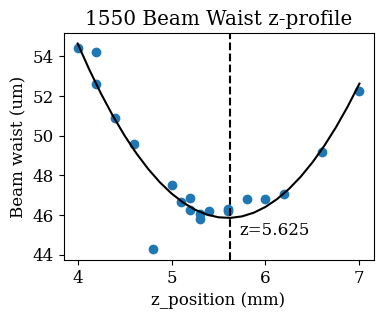

In [205]:
# 1550 z_pos to beam waist 

#arr = to_array(zpos)
#np.savetxt(fname,arr)
plt.rcParams.update({'font.size': 12,'font.sans-serif': 'Arial'})
w = 4
h = 3
d = 100
plt.figure(figsize=(w, h), dpi=d)

"""
zpos = np.loadtxt('beam waist/1550App.txt')
waist_arr = np.asarray([[x[0],pow2waist(0.75/2,x[2],x[1])] for x in np.asarray(zpos)])
plt.scatter(waist_arr[:,0],waist_arr[:,1],color='green')
"""

zpos2 = np.loadtxt('1550App2.txt')
waist_arr2 = np.asarray([[x[0],pow2waist(0.75/2,x[2],x[1])*100] for x in np.asarray(zpos2)])
plt.scatter(waist_arr2[:,0],waist_arr2[:,1])




plt.title('1550 Beam Waist z-profile')
plt.xlabel('z_position (mm)')
plt.ylabel('Beam waist (um)')


data_arr = waist_arr2[np.argsort(waist_arr2[:, 0])]

p_waist = np.poly1d(np.polyfit(data_arr[:,0], -data_arr[:,1], 2))

IS = np.linspace(data_arr[0][0],data_arr[-1][0],25)
plt.plot(IS,-p_waist(IS),color='black')
peaks = IS[find_peaks(p_waist(IS))[0]]
for i in peaks:
    plt.axvline(x=i,color='black',linestyle='--')
    #print('IS is at: ',round(i,2),'mm')
plt.text(6.1,45,fr'z={peaks[0]}',fontsize=12,ha='center')

waist_1550 = np.round(-p_waist(peaks[0])*1e-6,7) 

print('Z Apperture is at {}mm -> z Cal is at {}mm. This is 0.745mm less than previously used value of 5.5mm, provided that the difference in surace depth between calibration and aperture is indeed 0.87mm'.format(peaks[0],np.round(peaks[0]-0.87,3)))
print('Pump beam waist is {0}m'.format(waist_1550))


[[-1.12207e-05  8.58763e-07]
 [ 1.34972e-03  1.01200e-04]
 [-3.96591e-02  2.97847e-03]]


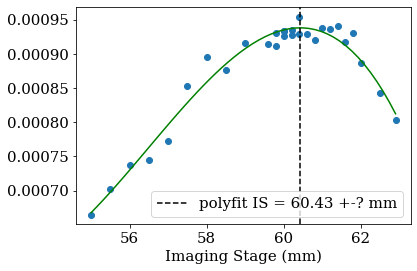

In [129]:
## 1064 Imaging stage (polyfit)

exp_data = np.loadtxt('1550_Butterfly.txt')
exp_data = exp_data[np.argsort(exp_data[:,0])]
p_disp = np.poly1d(np.polyfit(exp_data[:,0], exp_data[:,1], 3))

fit_range = np.linspace(np.min(exp_data[:,0]),np.max(exp_data[:,0]),50)

plt.rcParams.update({'font.size': 15})
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.scatter(exp_data[:,0],exp_data[:,1])
plt.plot(fit_range,p_disp(fit_range),color='green')
#plt.plot(fit_range,dp(fit_range))

# POLYFIT 
# compute local maxima
# excluding range boundaries
dp = p_disp.deriv().r
r_dp = dp[dp.imag==0].real
test = p_disp.deriv(2)(dp) 
x_max = r_dp[test<0]
y_max = p_disp(x_max) 

plt.xlabel('Imaging Stage (mm)')
plt.axvline(x_max,color='black',linestyle='--',label='polyfit IS = {} +-? mm'.format(np.round(x_max[0],2)))

# CURVEFIT 
def fit_func(x, *coeffs):
    y = np.polyval(coeffs, x)
    """
    This code evalues the x-coordinate of the local maximum 
    p = np.poly1d(coeffs)
    dp = p.deriv().r
    r_dp = dp[dp.imag==0].real
    test = p.deriv(2)(dp) 
    x_min = r_dp[test<0]
    y_min = p(x_min) 
    """
    return y

p_coeff = p_disp.coefficients

p_opt, p_cov = curve_fit(fit_func,exp_data[:,0],exp_data[:,1],p0=list(p_coeff))

p_err = np.sqrt(np.diag(p_cov))


def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

array = np.asarray([list(signif(x,6)) for x in zip(p_opt,p_err)])
print(array)

plt.legend()

From these simple polyfits the setup for the 1550nm laser reads as:

## z_pos = 5.5mm , IS = 60.43 mm

Note that z_pos defaults here, to the measured point of 6mm but ideally this should be at 6.2mm

Althoug without any assoicated errors (z assumed to be exact) it is hard to extract in confidence in this fit. 

The challenge comes particularly in deriving an error on the IS. It is easy enough to deirve one through error propogation for the y but the outstanding challenge, lies in root evaluation determine one for the maximum that properly accounts for the errors on the polyfit coeefs and their covariance, where significant.



In [130]:
## 1550 Imaging stage (Numerical Fit) 


# Note: Simultaneous beam waist fitting, results in cell taking up 1 minute to run

source = 'surface'

exp_data = np.loadtxt('1550_Butterfly.txt')
exp_data = exp_data[np.argsort(exp_data[:,0])]

#As both exp & theory should be normalised this line is required. However in all but the numerical fit (IS & w0), it leads to large #disagreements in final IS
exp_data[:,1] = exp_data[:,1]/y_max


def offset_disp(x,off,w0):

    #Slider here optimises the x alignment of both curves (off)
    disp_x = x - off
    #Find theoreretical peak to normalise the data
    normspace = np.linspace(np.max(disp_x),np.min(disp_x),20)
    normspace = np.asarray([Dispersion(1e2,1e-5,1.44,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0] for d in normspace])
    normf = normspace[find_peaks(normspace)[0][0]]
    disp = np.asarray([Dispersion(1e2,1e-5,1.44,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0]/normf for d in disp_x])
    return disp

p_opt, p_cov = curve_fit(offset_disp,exp_data[:,0],exp_data[:,1],p0=[64.5,46e-6],bounds=([58,44e-6],[70,52e-6]))

#print(p_opt,p_cov)
perr = np.sqrt(np.diag(p_cov))

# Evaluate Optimal Imaging stage 
x_z = np.linspace(-15,15,60)
D_fs = np.asarray([Dispersion(1e2,1e-5,1.44,1.38,2.2e3,703,0.14,407,p_opt[1],115e-6,1310e-9,d,source=source)[0] for d in x_z])
peak = p_opt[0]+x_z[find_peaks(D_fs)[0][0]]
#print(peak)
print('Imaging stage: {0}+-{1} mm , Beam waist {2}+-{3} um'.format(np.round(peak,2),np.round(perr[0],2),np.round(p_opt[1],7),np.round(perr[1],7)))


Imaging stage: 60.75+-0.13 mm , Beam waist 5.2e-05+-1.3e-06 um


In [ ]:
# Fit z from optimised imaging stage
# !!! IGNORE UNTIL w0 unccertanties are reduced

def poly_roots(p,y_value):
    # p should be of type poly1d 

    new_p = p.coefficients.copy() #Prevents original being overwritten
    new_p[-1] = new_p[-1] + y_value
    new_p = np.poly1d(new_p)
    return new_p

p2_waist  = poly_roots(p_waist,52)
z_fit = np.round(np.roots(p2_waist.coefficients)[-1],2)
print(fr'Fitted z={z_fit}mm, offset from z_app = {peaks[0]-z_fit}')

In [143]:
## 1550 Imaging stage optimisation 

# Fitting for IS only here but using a polyfit normalisation technique instead (to avoid errors of assigning maxium from a limited data set)

source = 'surface'

w0 = -p_waist(5.5)*1e-6# Where the imaging stage was actually measured
exp_data = np.loadtxt('1550_Butterfly.txt')
exp_data = exp_data[np.argsort(exp_data[:,0])]

#As both exp & theory should be normalised this line is required. However in all but the numerical fit (IS & w0), it leads to large #disagreements in final IS
exp_data[:,1] = exp_data[:,1]/y_max #Evaluated from the polyfit


def offset_disp(x,off,y_scale):
    #Slider here optimises the x alignment of both curves (off)
    disp_x = x - off
    #Find theoreretical peak for normalisation as oppose to the largest exp offset value provided its in range of Dispersion
    norm_x = np.linspace(np.max(disp_x),np.min(disp_x),20)
    normspace = np.asarray([Dispersion(1e2,1e-5,1.44,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0] for d in norm_x])
    normf = normspace[find_peaks(normspace)[0][0]]
    disp = np.asarray([y_scale*Dispersion(1e2,1e-5,1.44,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0]/normf for d in disp_x])
    return disp

p_opt, p_cov = curve_fit(offset_disp,exp_data[:,0],exp_data[:,1],p0=[60,1],bounds=[[60,0.98],[68,1.02]])
p_err = np.sqrt(np.diag(p_cov))

# Evaluate Optimal Imaging stage 
x_z = np.linspace(-15,0,60)
D_fs = np.asarray([Dispersion(1e2,1e-5,1.44,1.38,2.2e3,703,0.14,407,w0,115e-6,1310e-9,d,source=source)[0] for d in x_z])
peak = p_opt[0]+x_z[find_peaks(D_fs)[0][0]]
#print(peak)

print('Imaging stage: {0}+-{1} mm , Beam waist {2} um'.format(np.round(peak,2),np.round(p_err[0],2),np.round(-p_waist(6),4)))

Imaging stage: 56.51+-0.26 mm , Beam waist 46.4154 um
